# Analizando data API Twitter

In [ ]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import get_connection_covid_coaid,get_df_sql,remove_pattern,get_data_corpus
import pandas as pd
import psycopg2
from IPython.display import clear_output
from pandas_profiling import ProfileReport


import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import json
from collections import Counter
import re
import sys
import psycopg2
import time
import numpy as np

In [ ]:
conn = get_connection_covid_coaid()
sql = 'SELECT * FROM get_data_class_view;'
dfDataTweeter = get_df_sql(sql,conn)

In [ ]:
profile = ProfileReport(dfDataTweeter, title="Pandas Profiling Report")
profile.show()

### DATA CLEANING

- Removemos datos duplicados
- Hacemos uso de técnicas de limpieza, como la elminando emojis, users etiquetados, entre otros.
- Removemos stopwords haciendo uso el diccionario de stopwords de nltk 
- Eliminamos las terminaciones morfológicas e inflexionales más comunes de las palabras en inglés: nos quedamos con la raíz de la palabra

In [6]:
dfCleaned = dfDataTweeter.drop_duplicates()

In [7]:
text_tweet = dfCleaned['tweet_text']

In [8]:
def generate_word_cloud(corpus):
    all_words = ' '.join([text for text in corpus])
    wordcloud = WordCloud(width=1600, height=800, 
                          random_state=21, 
                          max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [9]:
data_remove = np.vectorize(remove_pattern)(text_tweet, "@[\w]*")

In [28]:
def get_data_corpus2(data_remove):
    corpus = []
    ps = PorterStemmer()
    for i in range(0, len(data_remove)):
        tweet = data_remove[i]
        tweet = tweet.lower()
        tweet = re.sub('rt', '', tweet)
        tweet =  re.sub(r"http\S+", "", tweet)
        tweet = re.sub('[^a-zA-Z0-9]', ' ', tweet)   
        tweet = tweet.split(' ')
        tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
        tweet = ' '.join(tweet)
        corpus.append(tweet)
    return corpus
data_corpus = get_data_corpus2(data_remove)

### Wordcloud

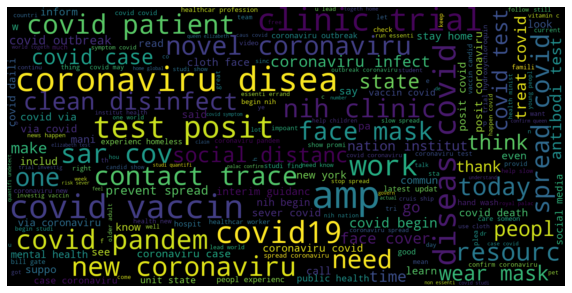

In [30]:
generate_word_cloud(data_corpus)

- Efectivamente, observamos que entre las palabras más utilizadas en las noticias falsas es usada la palabra covid19, coronaviru, vaccin, mask, need, treat.
- En menor medida podemos observar que ha sido mencionado Bill Gates, haciendo referencia a un rumor circulado hace un tiempo en redes.
- También vemos que otra palabra frecuente es bat(murciélago), del cual se cree proviene el virus.

In [31]:
dfCleaned['tweet_text'] = data_corpus

<ipython-input-31-d29d620e8662>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCleaned['tweet_text'] = data_corpus


In [33]:
profile = ProfileReport(dfCleaned, title="Pandas Profiling Report")
profile